In [1]:
import numpy as np
import matplotlib.pyplot as plt
import expsolve.fourier as ex

import torch
from torch import real, imag, exp, sin, cos, pi, abs,  matrix_exp, kron, eye

# The Grid

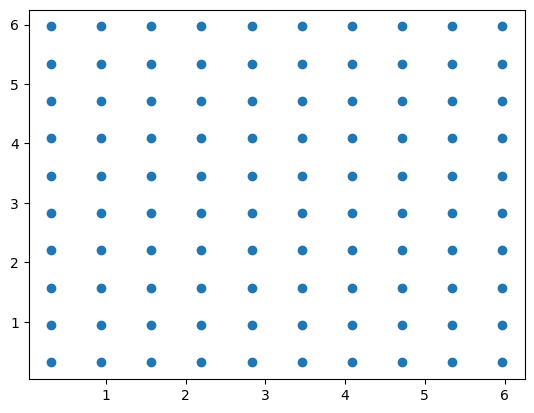

In [2]:
xrange = [0, 2*np.pi]
[x,y] = ex.grid([10,10], xrange)
plt.scatter(x,y)
plt.show()

# Testing differentiation

tensor([1.5866e-14], dtype=torch.float64)
tensor([3.0368e-13], dtype=torch.float64)


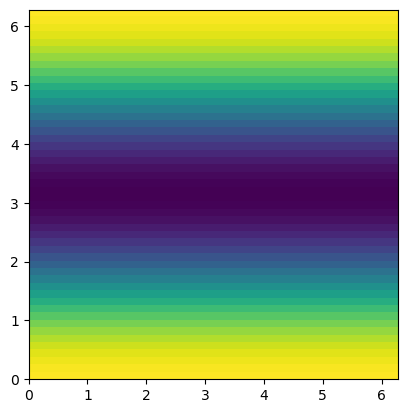

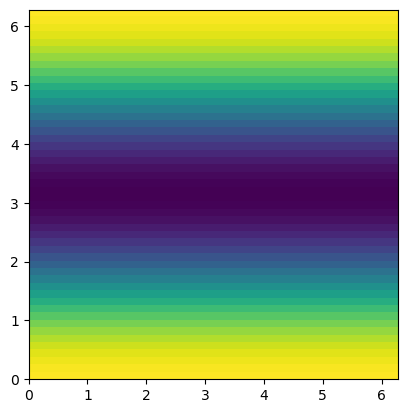

In [7]:
xrange = [0, 2*pi]
n = 50
[x,y] = ex.grid([n,n], xrange)
s = sin(x)
c = cos(x)
ds = ex.diffop(0,1,s,xrange)   
d2s = ex.diffop(0,2,s,xrange)  


print(ex.l2norm(c-ds, xrange))

print(ex.l2norm(-s-d2s, xrange))

plt.figure()
ex.imshow(plt, xrange, real(ds))
plt.show()

plt.figure()
ex.imshow(plt, xrange, c)
plt.show()

# Solving the Schrödinger equation

2D Grid

In [8]:
n = [50, 50]
xr = [-10, 10]
[x,y] = ex.grid(n, xr)

Initial Condition

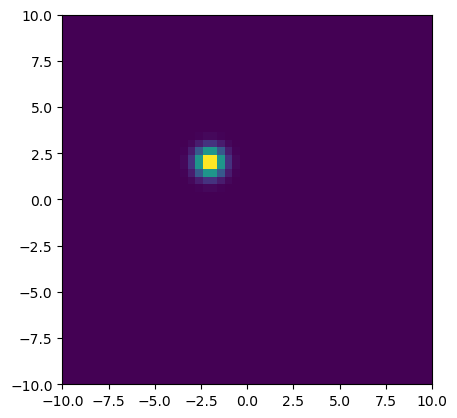

In [10]:
x0 = -2.0
y0 = -2.0
u = exp(-((x-x0)**2+(y-y0)**2)/(2*0.25))
u = ex.normalize(u, xr)     # normalize wavefunction and make it complex

ex.imshow(plt, xr, abs(u))
plt.show()

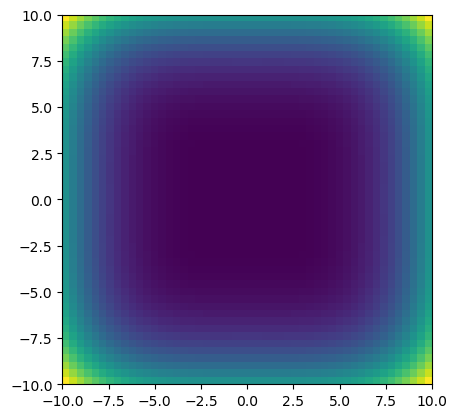

In [11]:
V = x**4 + y**4 - 5*x**2 - 5*y**2
ex.imshow(plt, xr, V)
plt.show()

### Single step of Strang

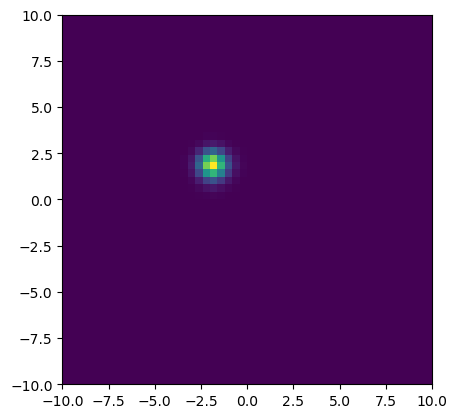

In [12]:
eL1u = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xr) 
eL2u = lambda h, u: ex.diffopexp(1, 2, 1j*h, u, xr)
eLu = lambda h, u: eL1u(h, eL2u(h, u))

eVu = lambda h, u: exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))


dt = 0.1

ustrang = strang(dt, u)

ex.imshow(plt, xr, abs(ustrang))
plt.show()

### Full run of Strang

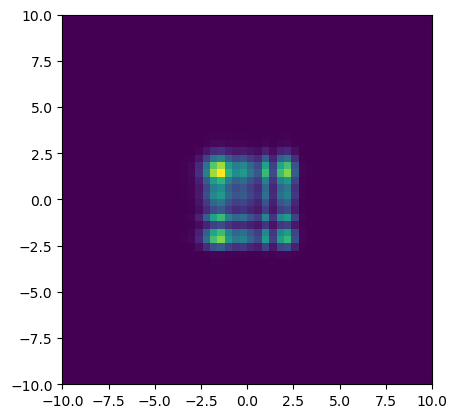

In [13]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

ustrangT = runstrang(T,1000,u)
ex.imshow(plt, xr, abs(ustrangT))
plt.show()

# Brute force approach

In [14]:
Ia = eye(n[0])
Ib = eye(n[1])
D2a = ex.diffmatrix(2, n[0], xr)
D2b = ex.diffmatrix(2, n[1], xr)
Lap = kron(D2a, Ib) + kron(Ia, D2b)

In [10]:
H = -Lap + ex.diag(V)
H = H.type(torch.complex128) 

In [11]:
T = 1.0
expH = matrix_exp(-1j*T*H)

In [12]:
urefT = expH @ u.flatten()
urefT = torch.reshape(urefT, tuple(n))

In [13]:
ex.l2norm(ustrangT-urefT, xr)

tensor(5.0808e-05, dtype=torch.float64)

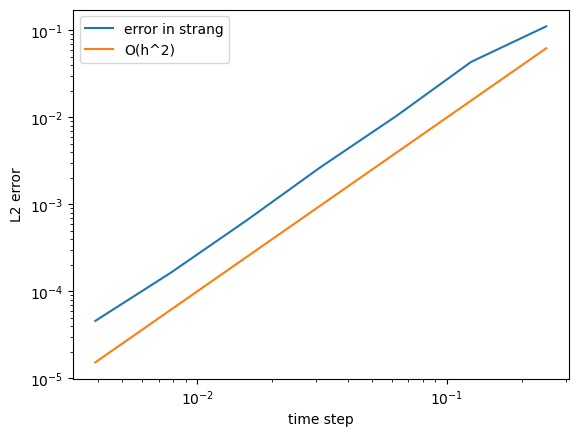

In [14]:
Nlist = 2**np.arange(2,9)
hlist = T/Nlist
err = [ex.l2norm(urefT-runstrang(T,N,u)) for N in Nlist]
plt.loglog(hlist, err)
plt.loglog(hlist, hlist**2)
plt.xlabel('time step')
plt.ylabel('L2 error')
plt.legend(['error in strang', 'O(h^2)'])
plt.show()